In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as pyp
import matplotlib as plt


In [2]:
# Data cleaning
def extract_data(data: pd.DataFrame) -> pd.DataFrame:
    # Name cleanup to get features of Title, Forename and Lastname
    data[["LastNm", "Name"]] = data["Name"].str.split(",", expand=True)
    data[["Title", "ForeNm"]] = data["Name"].str.split(
        ". ", n=1, expand=True, regex=False
    )
    data = data.drop(["Name"], axis=1)
    data["Sex"] = data["Sex"].astype("category").cat.codes

    obj_col = data.select_dtypes(["object"])
    data[obj_col.columns] = obj_col.apply(lambda x: x.str.strip())

    data["Rooms"] = (
        data["Cabin"]
        .fillna("Steerage")
        .str.split(" ", expand=False)
        .map(lambda x: 0 if x == ["Steerage"] else len(x))
    )

    data["Floor"] = data["Cabin"].fillna("Steerage").str[:1]

    data = data.drop(columns=["Ticket", "ForeNm", "LastNm", "PassengerId", "Cabin"])

    for c in data.columns:
        data[c] = data[c].fillna(data[c].mode()[0])

    return data


In [3]:
# Inputs
def standardize_inputs(df: pd.DataFrame) -> dict:
    inputs = {}
    for name, column in df.items():
        if type(column[0]) == str:
            dtype = tf.string
        elif name in categorical_features_names or name in binary_features_names:
            dtype = tf.int64
        elif name in numeric_features_names:
            dtype = tf.float32
        else:
            continue
        inputs[name] = tf.keras.Input(shape=(), name=name, dtype=dtype)

    return inputs


In [4]:
# Preprocessor
def create_preprocessor(
    inputs: dict,
    categorical_features_names: list,
    numeric_features_names: list,
    binary_features_names: list,
) -> tf.keras.Model():

    # Initialise the list of preprocessed values
    preprocessed = []

    # Binary
    for name in binary_features_names:
        inp = inputs[name]
        inp = inp[:, tf.newaxis]
        float_value = tf.cast(inp, tf.float32)
        preprocessed.append(float_value)

    # Numeric
    def stack_dict(inputs, fun=tf.stack):
        values = []
        for key in sorted(inputs.keys()):
            values.append(tf.cast(inputs[key], tf.float32))

        return fun(values, axis=-1)

    numeric_features = df[numeric_features_names]

    normalizer = tf.keras.layers.Normalization(axis=-1)
    normalizer.adapt(stack_dict(dict(numeric_features)))

    numeric_inputs = {}
    for name in numeric_features:
        numeric_inputs[name] = inputs[name]

    numeric_inputs = stack_dict(numeric_inputs)
    numeric_normalized = normalizer(numeric_inputs)

    preprocessed.append(numeric_normalized)

    # Categorical
    for name in categorical_features_names:
        vocab = sorted(set(df[name].dropna().values))

        if type(vocab[0]) is str:
            lookup = tf.keras.layers.StringLookup(
                vocabulary=vocab, output_mode="one_hot"
            )
        else:
            lookup = tf.keras.layers.IntegerLookup(
                vocabulary=vocab, output_mode="one_hot"
            )

        x = inputs[name][:, tf.newaxis]
        x = lookup(x)
        preprocessed.append(x)

    preprocesssed_result = tf.concat(preprocessed, axis=-1)
    return tf.keras.Model(inputs, preprocesssed_result)


In [5]:
# Fetch the data
df = extract_data(pd.read_csv("train.csv"))


In [6]:
# Build Training, validation, and testing sets features & labels
LABEL = "Survived"
target = df.pop(LABEL).to_numpy(dtype=np.int64)


In [7]:
# Create the preprocessor
categorical_features_names = ["Embarked", "Title", "Floor", "Pclass"]
numeric_features_names = ["SibSp", "Age", "Parch", "Fare", "Rooms"]
binary_features_names = ["Sex"]
inputs = standardize_inputs(df)
preprocessor = create_preprocessor(
    inputs=inputs,
    categorical_features_names=categorical_features_names,
    numeric_features_names=numeric_features_names,
    binary_features_names=binary_features_names,
)


2022-04-02 21:53:37.901123: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


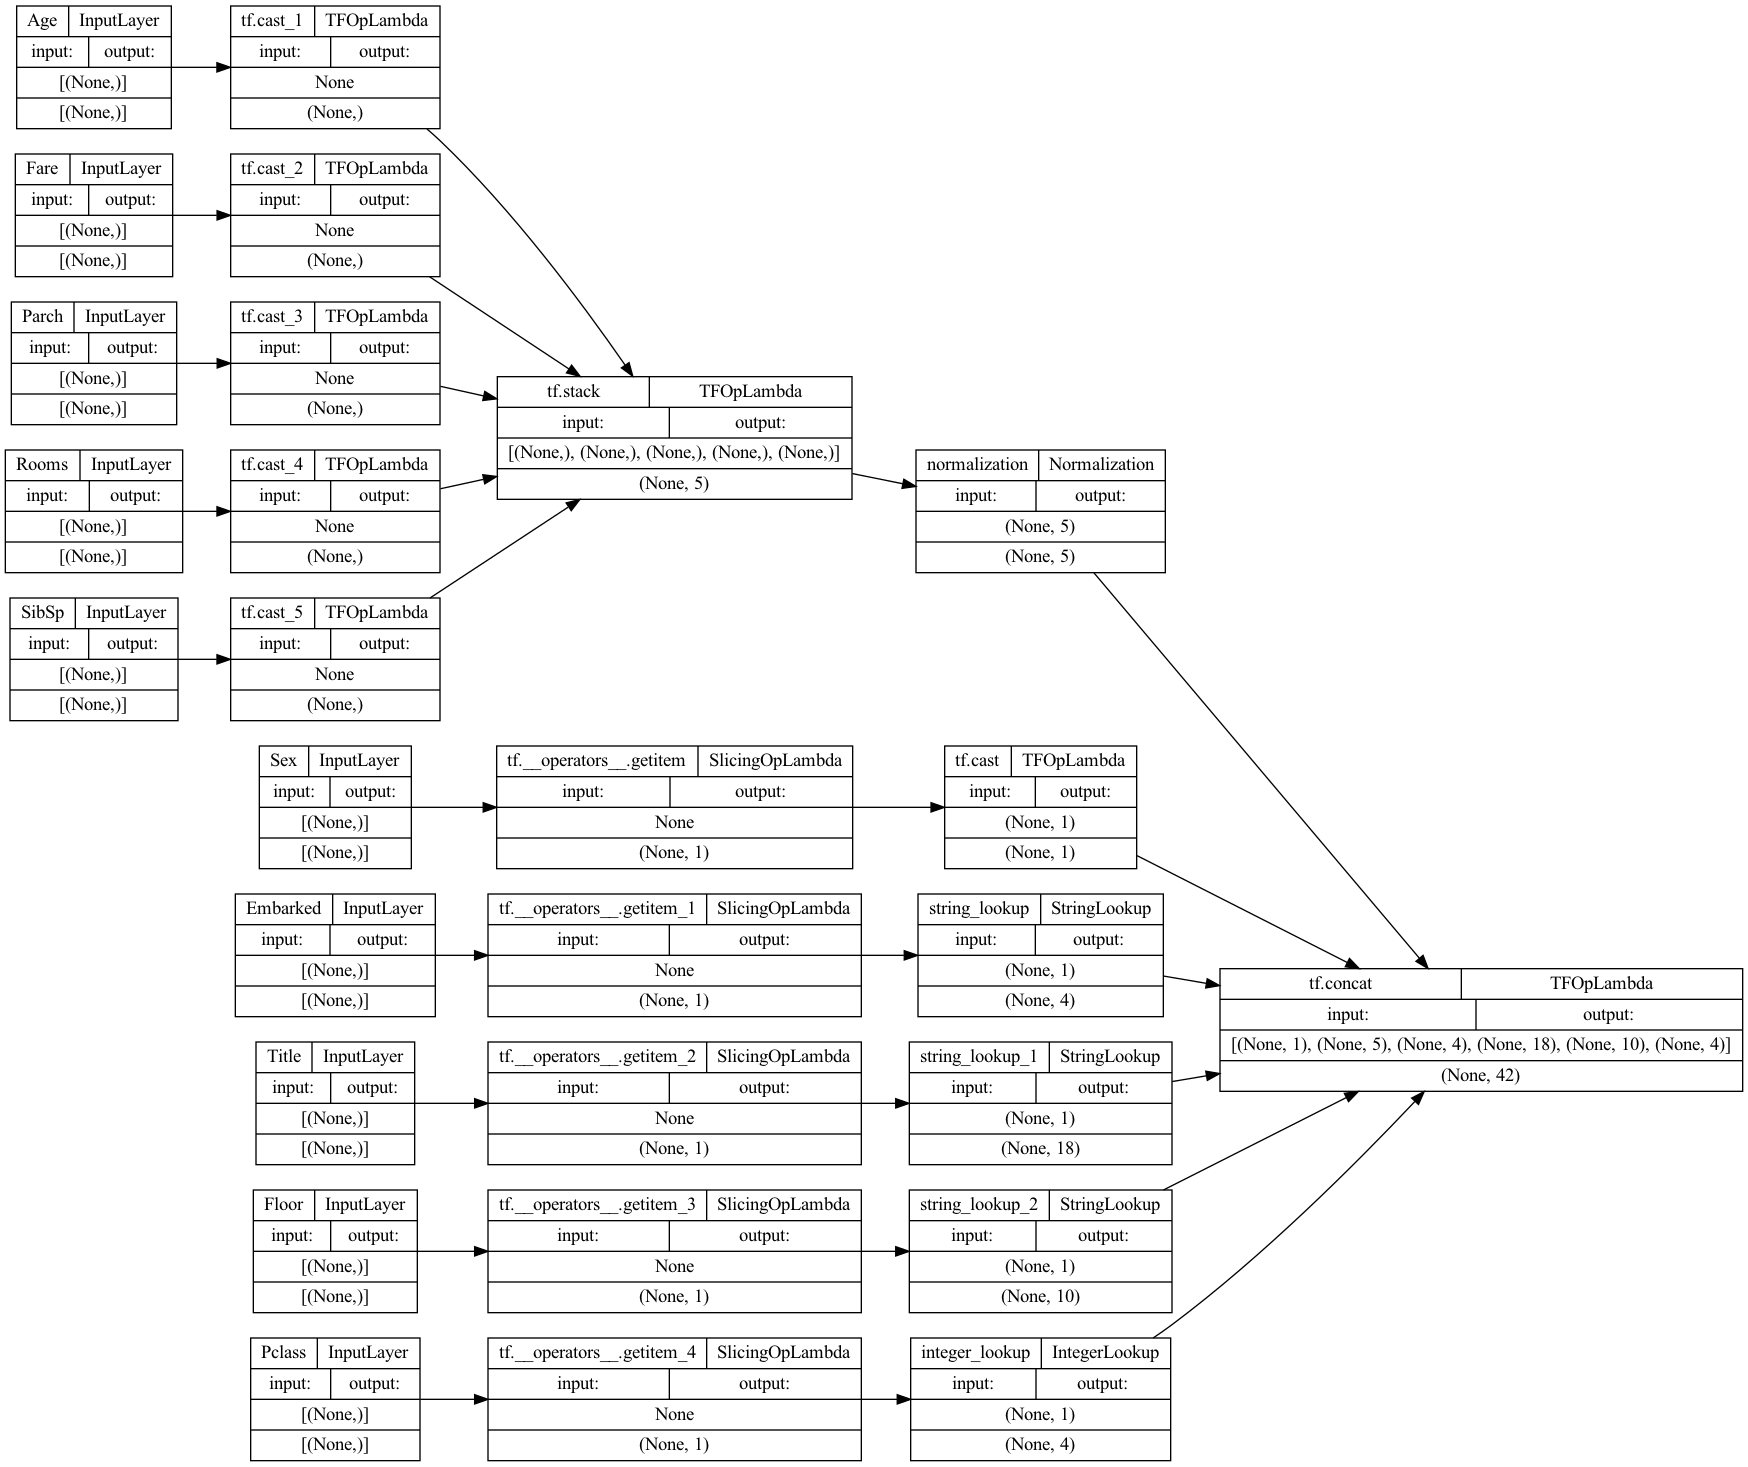

In [8]:
# Plot the preprocessor
tf.keras.utils.plot_model(preprocessor, rankdir="LR", show_shapes=True)


In [9]:
def plot_history(history):


    pyp.style.use("seaborn")
    fig, ax = pyp.subplots(1, 2, figsize=(10, 4))

    ax[0].set_title(f"accuracy for {history.model.name}", color="C0")
    ax[1].set_title(f"loss for {history.model.name}", color="C0")

    ax[0].plot(history.history["accuracy"], color="tab:blue", label="Train Accuracy")
    ax[0].plot(
        history.history["val_accuracy"], color="tab:orange", label="Val Accuracy"
    )
    ax[1].plot(
        history.history["loss"],
        color="tab:blue",
        linestyle="dotted",
        label="Train Loss",
    )
    ax[1].plot(
        history.history["val_loss"],
        color="tab:orange",
        linestyle="dotted",
        label="Val Loss",
    )
    ax[0].legend(loc="lower right")
    ax[1].legend(loc="upper right")


In [10]:
class lr_finder():
    # https://www.kaggle.com/code/rivesunder/optimizing-learning-rate-in-keras/notebook
    
    def __init__(self,model,begin_lr=1e-8, end_lr=1e-1, num_epochs=10, period=5):
        # lr_finder generates learning schedules for finding upper and lower bounds on the best learning rate, as well as 
        # a cyclical learning rate schedule based on those bounds
        self.period = period
        # make a copy of the model to train through a sweep of learning rates
        self.model = tf.keras.models.clone_model(model)
        
        # define bounds to sweep through
        self.begin_lr = np.log(begin_lr)/np.log(10)
        self.end_lr = np.log(end_lr)/np.log(10)
        self.num_epochs = num_epochs
        self.lower_bound = begin_lr
        self.upper_bound = 1e-2 #end_lr
        # define learning rates to use in schedules
        self.lr = np.logspace(self.begin_lr,self.end_lr,self.num_epochs)
        self.clr = np.logspace(np.log(self.lower_bound)/np.log(10), np.log(self.upper_bound)/np.log(10), self.period)
        
        
    def reset_model(self, model):
        # reset the model to find new lr bounds 
        self.begin_lr = -10 
        self.end_lr = 0 
        self.lr = np.logspace(self.begin_lr,self.end_lr,self.num_epochs)
        self.model = tf.keras.models.clone_model(model)
        
    def lr_schedule(self,epoch):
        # return lr according to a sweeping schedule
        if epoch < self.num_epochs:
            return self.lr[epoch]
        else:
            return self.lr[0]
        
    def clr_schedule(self,epoch,period=5):
        # return lr according to cyclical learning rate schedule
        my_epoch = int(epoch % self.period)
        return self.clr[my_epoch]
    
    def lr_vector(self,epochs):
        # return the vector of learning rates used in a schedule
        lrv = []
        for ck in range(epochs):
            lrv.append(self.lr_schedule(ck))
        return lrv
    
    def lr_plot(self,history_loss,please_plot=True):
        # plot the lr sweep results and set upper and lower bounds on learning rate
        x_axis = self.lr_vector(self.num_epochs)
        y_axis = history_loss
                   
        d_loss = []
        for cc in range(1,len(y_axis)):
            if cc == 1:
                d_loss.append(y_axis[cc] - y_axis[cc-1])
            else:
                d_loss.append(0.8*(y_axis[cc] - y_axis[cc-1])+0.2*(y_axis[cc-1] - y_axis[cc-2]))
        d_loss = np.array(d_loss)
        
        self.lower_bound = x_axis[d_loss.argmin()]
        self.upper_bound = x_axis[np.array(y_axis).argmin()]
        self.clr = np.logspace(np.log(self.lower_bound)/np.log(10), np.log(self.upper_bound)/np.log(10), self.period)
        
        print("recommended learning rate: more than %.2e, less than %.2e "%(self.lower_bound, self.upper_bound))
        if(please_plot):
            pyp.figure(figsize=(10,5))
            pyp.loglog(x_axis,y_axis)
            pyp.xlabel('learning rate')
            pyp.ylabel('loss')
            pyp.title('Loss / learning rate progression')
            pyp.show()
            
    def get_lr(self,epoch):
        # return the geometric mean of the upper and lower bound learning rates
        return (self.lower_bound *self.upper_bound)**(1/2)
    

In [11]:
def lr_test_model(inputs, preprocessor, sequential, EPOCHS, BATCH_SIZE, VALIDATION_SPLIT):

    x = preprocessor(inputs)
    result = sequential(x)
    model = tf.keras.Model(inputs, result)

    steps_per_epoch = int(len(target)/BATCH_SIZE)

    lrf = lr_finder(model, begin_lr=1e-8, end_lr=1e0, num_epochs=EPOCHS)
    lr_rate = tf.keras.callbacks.LearningRateScheduler(lrf.lr_schedule)

    lrf.model.compile(
        optimizer=tf.keras.optimizers.RMSprop(),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=["accuracy"],
    )

    history = lrf.model.fit(
        dict(df),
        target,
        epochs=EPOCHS,
        steps_per_epoch=steps_per_epoch/20,
        batch_size=BATCH_SIZE,
        validation_split=VALIDATION_SPLIT,
        verbose=0,
        callbacks=[lr_rate],
    )

    lrf.lr_plot(history.history['loss'])

    plot_history(history)

    return lrf.model, history


In [12]:
def run_model(inputs, preprocessor, sequential, EPOCHS, BATCH_SIZE, VALIDATION_SPLIT, LEARNING_RATE):

    x = preprocessor(inputs)
    result = sequential(x)
    model = tf.keras.Model(inputs, result)

    steps_per_epoch = int(len(target)/BATCH_SIZE)

    model.compile(
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=LEARNING_RATE),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=["accuracy"],
    )

    history = model.fit(
        dict(df),
        target,
        epochs=EPOCHS,
        steps_per_epoch=steps_per_epoch/20,
        batch_size=BATCH_SIZE,
        validation_split=VALIDATION_SPLIT,
        verbose=0,
    )

    plot_history(history)

    return model, history

recommended learning rate: more than 6.76e-02, less than 8.24e-03 


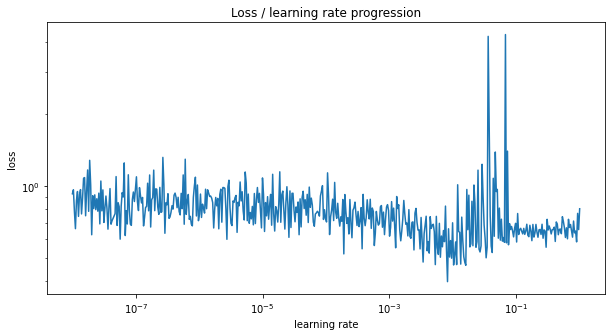

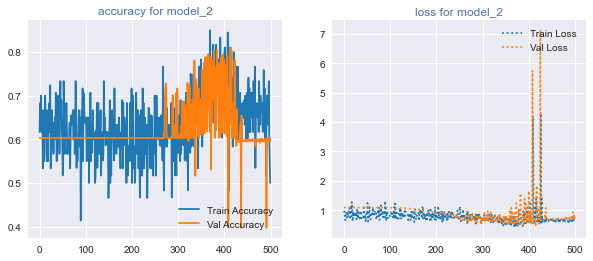

In [13]:
# Model 1
EPOCHS = 500
BATCH_SIZE = 20
VALIDATION_SPLIT = 0.8

sequential1 = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(42, activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(200, activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(200, activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)

lr_model1, lr_history1= lr_test_model(
    inputs, preprocessor, sequential1, EPOCHS, BATCH_SIZE, VALIDATION_SPLIT
)



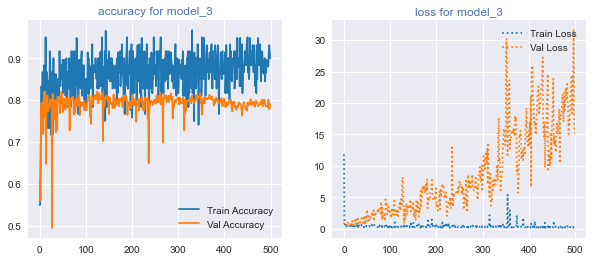

In [14]:
LEARNING_RATE = 3.5e-2
model1, history1= run_model(
    inputs, preprocessor, sequential1, EPOCHS, BATCH_SIZE, VALIDATION_SPLIT, LEARNING_RATE
)

recommended learning rate: more than 1.05e-01, less than 8.87e-03 


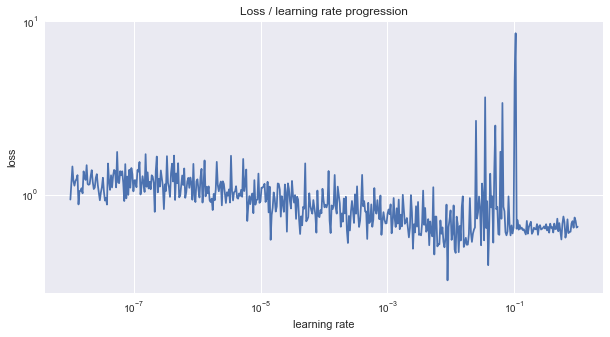

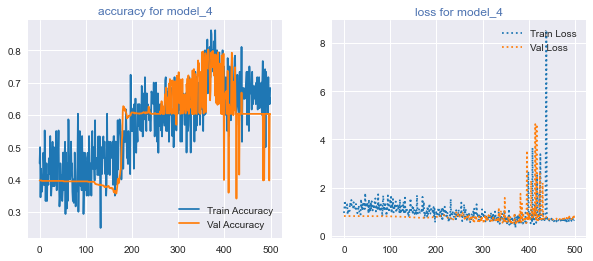

In [15]:
# Model 2
EPOCHS = 500
BATCH_SIZE = 20
VALIDATION_SPLIT = 0.8

sequential2 = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(1000),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(1000),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)

lr_model2, lr_history2= lr_test_model(
    inputs, preprocessor, sequential1, EPOCHS, BATCH_SIZE, VALIDATION_SPLIT
)

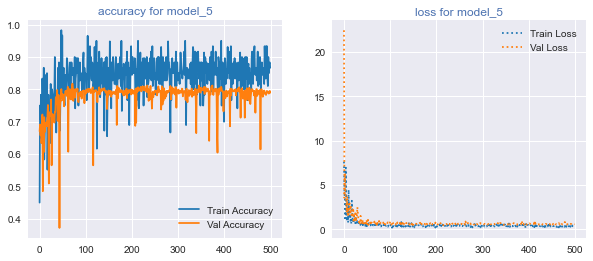

In [16]:
LEARNING_RATE = 2e-2
model2, history2= run_model(
    inputs, preprocessor, sequential2, EPOCHS, BATCH_SIZE, VALIDATION_SPLIT, LEARNING_RATE
)

recommended learning rate: more than 8.75e-02, less than 1.15e-02 


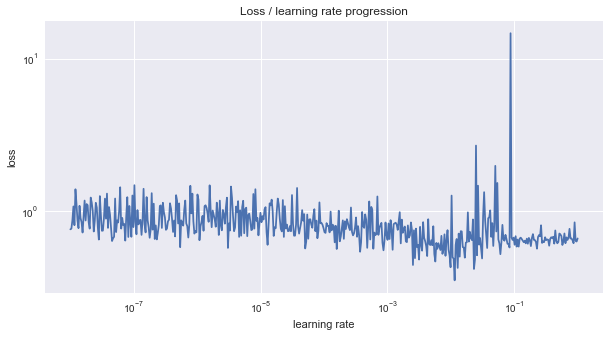

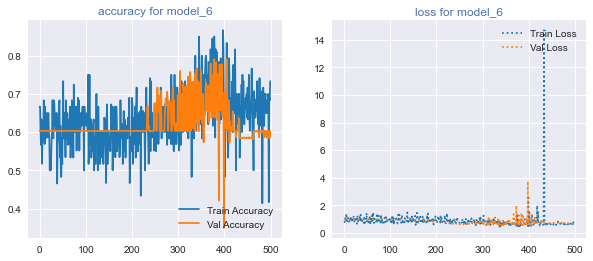

In [17]:
# Model 3
EPOCHS = 500
BATCH_SIZE = 20
VALIDATION_SPLIT = 0.8

sequential3 = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(21),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)

lr_model3, lr_history3= lr_test_model(
    inputs, preprocessor, sequential1, EPOCHS, BATCH_SIZE, VALIDATION_SPLIT
)

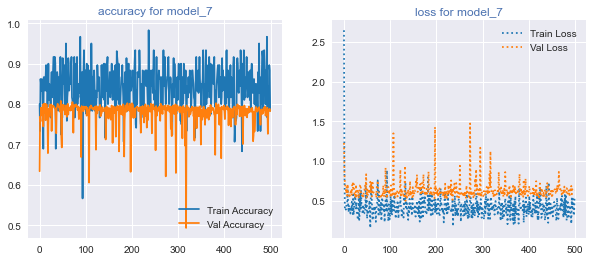

In [18]:
LEARNING_RATE = 2.7e-2
model3, history3= run_model(
    inputs, preprocessor, sequential2, EPOCHS, BATCH_SIZE, VALIDATION_SPLIT, LEARNING_RATE
)

In [19]:
# # Generate predictions
# predict_df = extract_data(pd.read_csv("test.csv"))
# predict_array = standardize_inputs(predict_df)
# predictions = (model5.predict(dict(predict_df)) > 0.5).astype(int).ravel()
# submit = pd.DataFrame(
#     {"PassengerId": pd.read_csv("test.csv")["PassengerId"], "Survived": predictions}
# )
